# RAG vs Context Stuffing
Large context windows have dramatically increased how much information modern language models can process in a single prompt. With models capable of handling hundreds of thousands—or even millions—of tokens, it’s easy to assume that Retrieval-Augmented Generation (RAG) is no longer necessary. If you can fit an entire codebase or documentation library into the context window, why build a retrieval pipeline at all?

The key distinction is that a context window defines how much the model can see, while RAG determines what the model should see. A large window increases capacity, but it does not improve relevance. RAG filters and selects the most important information before it reaches the model, improving signal-to-noise ratio, efficiency, and reliability. The two approaches solve different problems and are not substitutes for one another.

In this article, we compare both strategies directly. Using the OpenAI API, we evaluate Retrieval-Augmented Generation against brute-force context stuffing on the same documentation corpus. We measure token usage, latency, and cost—and demonstrate how burying critical information inside large prompts can affect model performance. The results highlight why large context windows complement RAG rather than replace it.

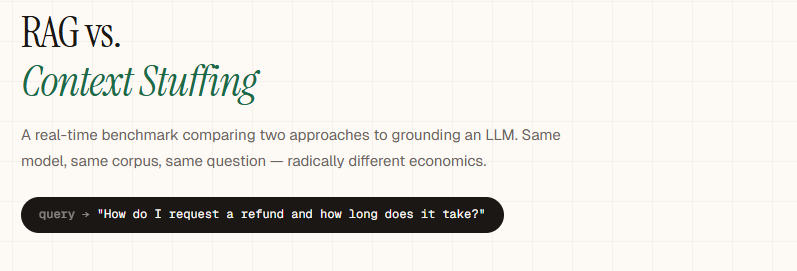

## Installing the dependencies

In [1]:
import os
import time
import textwrap
import numpy as np
import tiktoken
from openai import OpenAI

In [2]:
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass('Enter OpenAI API Key: ')
client = OpenAI()

Enter OpenAI API Key: ··········


We use text-embedding-3-small as the embedding model to convert documents and queries into vector representations for efficient semantic retrieval. For generation and reasoning, we use gpt-4o, with token accounting handled via its corresponding tiktoken encoding to accurately measure context size and cost.

In [3]:
EMBED_MODEL = "text-embedding-3-small"
CHAT_MODEL  = "gpt-4o"
ENC         = tiktoken.encoding_for_model("gpt-4o")

## Creating the document corpus
This corpus serves as the retrieval source for our benchmark. In the RAG setup, embeddings are generated for each document and relevant chunks are retrieved based on semantic similarity. In the context-stuffing setup, the entire corpus is injected into the prompt. Because the documents contain specific numeric clauses (e.g., time limits, rate caps, refund windows), they are well-suited for testing retrieval accuracy, signal density, and the “Lost in the Middle” effect under large-context conditions.

The corpus consists of 10 structured policy documents totaling approximately 650 tokens, with each document ranging between 54 and 83 tokens. This size keeps the dataset manageable while still reflecting the diversity and density of a realistic enterprise documentation set.

Although relatively small, the corpus includes tightly packed numerical clauses, conditional rules, and compliance statements—making it suitable for evaluating retrieval precision, reasoning accuracy, and token efficiency. It provides a controlled environment to compare RAG-based selective retrieval against full context stuffing without introducing external noise.

In [4]:
def count_tokens(text: str) -> int:
    return len(ENC.encode(text))

In [5]:
DOCS = [
    {
        "id": 1, "title": "Refund Policy",
        "content": (
            "Customers may request a full refund within 30 days of purchase. "
            "Refunds are processed within 5–7 business days to the original payment method. "
            "Digital products are non-refundable once the download link has been accessed. "
            "Subscription cancellations stop future charges but do not trigger automatic refunds "
            "for the current billing cycle unless the cancellation is made within 48 hours of renewal."
        )
    },
    {
        "id": 2, "title": "Shipping Information",
        "content": (
            "Standard shipping takes 5–7 business days. Express shipping delivers in 2–3 business days. "
            "Orders over $50 qualify for free standard shipping within the continental US. "
            "International shipping is available to 30 countries and takes 10–21 business days. "
            "Tracking numbers are emailed within 24 hours of dispatch."
        )
    },
    {
        "id": 3, "title": "Account Security",
        "content": (
            "Two-factor authentication (2FA) can be enabled from the Security tab in account settings. "
            "Passwords must be at least 12 characters and include one uppercase letter, one number, "
            "and one special character. Active sessions expire after 30 days of inactivity. "
            "Suspicious login attempts trigger an automatic account lock and a reset email."
        )
    },
    {
        "id": 4, "title": "API Rate Limits",
        "content": (
            "Free tier: 100 requests per day, max 10 requests per minute. "
            "Pro tier: 10 000 requests per day, max 200 requests per minute. "
            "Enterprise tier: unlimited requests, burst up to 1 000 per minute. "
            "All responses include X-RateLimit-Remaining and X-RateLimit-Reset headers. "
            "Exceeding limits returns HTTP 429 with a Retry-After header."
        )
    },
    {
        "id": 5, "title": "Data Privacy & GDPR",
        "content": (
            "All user data is encrypted at rest using AES-256 and in transit using TLS 1.3. "
            "We never sell or rent personal data to third parties. "
            "The platform is fully GDPR and CCPA compliant. "
            "Data deletion requests are processed within 72 hours. "
            "Users can export all their data in JSON or CSV format from the Privacy section."
        )
    },
    {
        "id": 6, "title": "Billing & Subscription Cycles",
        "content": (
            "Subscriptions renew automatically on the same calendar day each month. "
            "Annual plans offer a 20 % discount compared to monthly billing. "
            "Invoices are sent via email 3 days before each renewal. "
            "Failed payments retry three times over 7 days before the account is downgraded."
        )
    },
    {
        "id": 7, "title": "Supported File Formats",
        "content": (
            "Supported upload formats: PDF, DOCX, XLSX, PPTX, PNG, JPG, WebP, MP4, MOV. "
            "Maximum individual file size is 100 MB. "
            "Batch uploads support up to 50 files simultaneously. "
            "Files are virus-scanned on upload and quarantined if threats are detected."
        )
    },
    {
        "id": 8, "title": "Compliance Certifications",
        "content": (
            "The platform holds SOC 2 Type II certification, renewed annually. "
            "ISO 27001 compliance is maintained with quarterly internal audits. "
            "A HIPAA Business Associate Agreement (BAA) is available for healthcare customers on the Enterprise plan. "
            "PCI-DSS Level 1 compliance covers all payment processing flows."
        )
    },
    {
        "id": 9, "title": "SLA & Uptime Guarantees",
        "content": (
            "Enterprise SLA guarantees 99.9 % monthly uptime (≤ 43 minutes downtime/month). "
            "Scheduled maintenance windows occur every Sunday between 02:00–04:00 UTC. "
            "Unplanned incidents are communicated via status.example.com within 15 minutes. "
            "SLA breaches are compensated with service credits applied to the next invoice."
        )
    },
    {
        "id": 10, "title": "Cancellation Policy",
        "content": (
            "Users can cancel at any time from the Subscription tab in account settings. "
            "Annual plan holders receive a pro-rated refund for unused months if cancelled within 30 days of renewal. "
            "Cancellation takes effect at the end of the current billing period; access continues until then. "
            "Re-activation within 90 days of cancellation restores all historical data."
        )
    },
]


In [6]:
total_tokens = sum(count_tokens(d["content"]) for d in DOCS)
print(f"Corpus: {len(DOCS)} documents | {total_tokens} tokens total\n")
for d in DOCS:
    print(f"  [{d['id']:02d}] {d['title']:<35} ({count_tokens(d['content'])} tokens)")

Corpus: 10 documents | 650 tokens total

  [01] Refund Policy                       (71 tokens)
  [02] Shipping Information                (63 tokens)
  [03] Account Security                    (65 tokens)
  [04] API Rate Limits                     (83 tokens)
  [05] Data Privacy & GDPR                 (68 tokens)
  [06] Billing & Subscription Cycles       (54 tokens)
  [07] Supported File Formats              (61 tokens)
  [08] Compliance Certifications           (58 tokens)
  [09] SLA & Uptime Guarantees             (62 tokens)
  [10] Cancellation Policy                 (65 tokens)


## Building the Embedding Index
We generate vector embeddings for all 10 documents using the text-embedding-3-small model and store them in a NumPy array. Each document is converted into a 1,536-dimensional float32 vector, producing an index with shape (10, 1536).

The entire indexing step completes in 1.82 seconds, demonstrating how lightweight semantic indexing is at this scale. This vector matrix now acts as our retrieval layer—enabling fast similarity search during the RAG workflow instead of scanning raw text at inference time.

In [7]:
def embed_texts(texts: list[str]) -> np.ndarray:
    """Call OpenAI Embeddings API and return a (N, 1536) float32 array."""
    response = client.embeddings.create(model=EMBED_MODEL, input=texts)
    return np.array([item.embedding for item in response.data], dtype=np.float32)

print("Building index … ", end="", flush=True)
t0 = time.perf_counter()

corpus_texts = [d["content"] for d in DOCS]
index        = embed_texts(corpus_texts)          # shape: (10, 1536)

elapsed = time.perf_counter() - t0
print(f"done in {elapsed:.2f}s  |  index shape: {index.shape}")

Building index … done in 1.82s  |  index shape: (10, 1536)


## Retrieval and Prompt helpers
The below functions implement the full comparison pipeline between RAG and context stuffing.

* retrieve() embeds the user query, computes cosine similarity via a dot product
against the precomputed index, and returns the top-k most relevant documents with similarity scores. Because text-embedding-3-small outputs unit-norm vectors, the dot product directly represents cosine similarity—keeping retrieval both simple and efficient.

* build_rag_prompt() constructs a focused prompt using only the retrieved chunks, ensuring high signal density and minimal irrelevant context.

* build_stuffed_prompt() constructs a brute-force prompt by injecting the entire corpus into the context, simulating the “just use the whole window” approach.

* call_llm() sends the prompt to gpt-4o, measures latency, and captures token usage, allowing us to directly compare cost, speed, and efficiency between the two strategies.

Together, these helpers create a controlled environment to benchmark retrieval precision versus raw context capacity.

In [12]:
def retrieve(query: str, k: int = 3) -> list[dict]:
    """
    Embed the query, compute cosine similarity against the index,
    and return the top-k document dicts with their scores.

    text-embedding-3-small returns unit-norm vectors, so the dot product
    IS cosine similarity — no extra normalisation needed.
    """
    q_vec   = embed_texts([query])[0]             # shape: (1536,)
    scores  = index @ q_vec                       # dot product = cosine similarity
    top_idx = np.argsort(scores)[::-1][:k]        # top-k indices, highest first
    return [{"doc": DOCS[i], "score": float(scores[i])} for i in top_idx]


def build_rag_prompt(query: str, chunks: list[dict]) -> str:
    """Build a focused prompt from only the retrieved chunks."""
    context_parts = [
        f"[Source: {c['doc']['title']}]\n{c['doc']['content']}"
        for c in chunks
    ]
    context = "\n\n---\n\n".join(context_parts)
    return (
        f"You are a helpful support assistant. "
        f"Answer the question below using the provided context. "
        f"Be specific and direct.\n\n"
        f"CONTEXT:\n{context}\n\n"
        f"QUESTION: {query}"
    )


def build_stuffed_prompt(query: str) -> str:
    """Build a prompt that dumps the entire corpus into the context."""
    context_parts = [
        f"[Source: {d['title']}]\n{d['content']}"
        for d in DOCS
    ]
    context = "\n\n---\n\n".join(context_parts)
    return (
        f"You are a helpful support assistant. "
        f"Answer the question below using the provided context. "
        f"Be specific and direct.\n\n"
        f"CONTEXT:\n{context}\n\n"
        f"QUESTION: {query}"
    )


def call_llm(prompt: str) -> tuple[str, float, int, int]:
    """Returns (answer, latency_ms, input_tokens, output_tokens)."""
    t0  = time.perf_counter()
    res = client.chat.completions.create(
        model       = CHAT_MODEL,
        messages    = [{"role": "user", "content": prompt}],
        temperature = 0,
    )
    latency_ms = (time.perf_counter() - t0) * 1000
    answer     = res.choices[0].message.content.strip()
    return answer, latency_ms, res.usage.prompt_tokens, res.usage.completion_tokens

## Comparing the approaches
This block runs a direct, side-by-side comparison between Retrieval-Augmented Generation (RAG) and brute-force context stuffing using the same user query. In the RAG approach, the system first retrieves the top three most relevant documents based on semantic similarity, builds a focused prompt using only those chunks, and then sends that condensed context to the model. It also prints similarity scores, token counts, and latency, allowing us to observe how much context is actually required to answer the question effectively.

In contrast, the context-stuffing approach constructs a prompt that includes all 10 documents, regardless of relevance, and sends the entire corpus to the model. By measuring input tokens, output tokens, and response time for both methods under identical conditions, we isolate the architectural difference between selective retrieval and brute-force loading. This makes the trade-offs in efficiency, cost, and performance concrete rather than theoretical.

In [13]:
QUERY = "How do I request a refund and how long does it take"

In [14]:
DIVIDER = "─" * 65

print(f"\n{'='*65}")
print(f"  QUERY: {QUERY}")
print(f"{'='*65}\n")

# ── RAG ──────────────────────────────────────────────────────────────────────
print("[ APPROACH 1 ]  RAG  (retrieve then reason)")
print(DIVIDER)

chunks     = retrieve(QUERY, k=3)
rag_prompt = build_rag_prompt(QUERY, chunks)

print(f"Top-{len(chunks)} retrieved chunks:")
for c in chunks:
    preview = c["doc"]["content"][:75].replace("\n", " ")
    print(f"  • {c['doc']['title']:<40}  similarity: {c['score']:.4f}")
    print(f"    \"{preview}...\"")

print(f"\nTotal tokens being sent to LLM: {count_tokens(rag_prompt)}\n")

rag_answer, rag_latency, rag_in, rag_out = call_llm(rag_prompt)

print(f"Answer:\n{textwrap.fill(rag_answer, 65)}")
print(f"\nTokens  →  input: {rag_in:>6,}  |  output: {rag_out:>4,}  |  total: {rag_in+rag_out:>6,}")
print(f"Latency →  {rag_latency:,.0f} ms\n")


# ── Approach 2: Context Stuffing ──────────────────────────────────────────────
print("[ APPROACH 2 ]  Context Stuffing  (dump everything, then reason)")
print(DIVIDER)

stuffed_prompt = build_stuffed_prompt(QUERY)
print(f"Sending all {len(DOCS)} documents ({count_tokens(stuffed_prompt):,} tokens) to the LLM ...\n")

stuff_answer, stuff_latency, stuff_in, stuff_out = call_llm(stuffed_prompt)

print(f"Answer:\n{textwrap.fill(stuff_answer, 65)}")
print(f"\nTokens  →  input: {stuff_in:>6,}  |  output: {stuff_out:>4,}  |  total: {stuff_in+stuff_out:>6,}")
print(f"Latency →  {stuff_latency:,.0f} ms\n")


  QUERY: How do I request a refund and how long does it take

[ APPROACH 1 ]  RAG  (retrieve then reason)
─────────────────────────────────────────────────────────────────
Top-3 retrieved chunks:
  • Refund Policy                             similarity: 0.5351
    "Customers may request a full refund within 30 days of purchase. Refunds are..."
  • Cancellation Policy                       similarity: 0.3763
    "Users can cancel at any time from the Subscription tab in account settings...."
  • API Rate Limits                           similarity: 0.2824
    "Free tier: 100 requests per day, max 10 requests per minute. Pro tier: 10 0..."

Total tokens being sent to LLM: 278

Answer:
To request a refund, you need to do so within 30 days of your
purchase. Once you have requested a refund, it will be processed
within 5–7 business days and will be returned to your original
payment method. Note that digital products are non-refundable if
the download link has already been accessed.

Tokens

The results show that both approaches produce a correct and nearly identical answer — but the efficiency profile is very different.

With RAG, only the three most relevant documents were retrieved, resulting in 278 tokens sent to the model (285 actual prompt tokens). The total token usage was 347, and the response latency was 783 ms. The retrieved chunks clearly prioritized the Refund Policy, which directly contains the answer, while the remaining two documents were secondary matches based on semantic similarity.

With context stuffing, all 10 documents were injected into the prompt, increasing the input size to 775 tokens and total usage to 834 tokens. Latency nearly doubled to 1,518 ms. Despite processing more than twice the input tokens, the model produced essentially the same answer.

The key takeaway is not that stuffing fails — it works at small scale — but that it is inefficient. RAG achieved the same output with less than half the tokens and roughly half the latency. As corpus size grows from 10 documents to thousands, this gap compounds dramatically. What appears harmless at 768 tokens becomes prohibitively expensive and slow at 500k+ tokens. This is the economic and architectural argument for retrieval: optimize signal before reasoning.

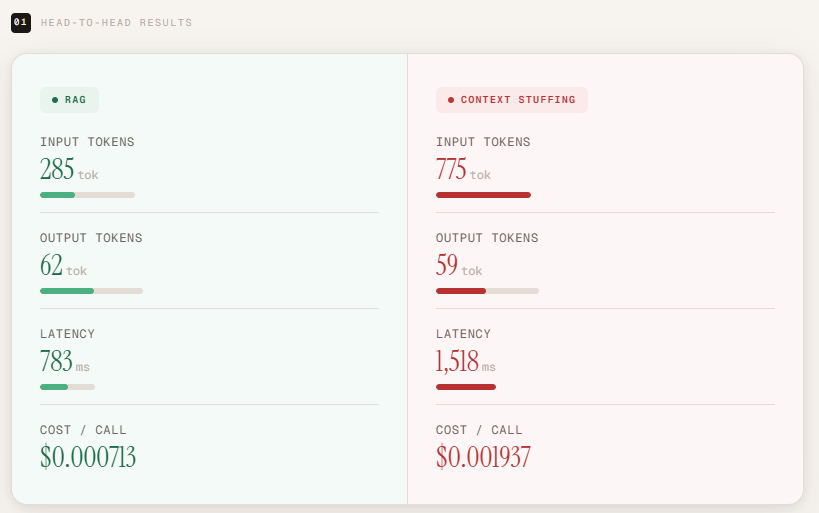

In [16]:
token_ratio   = stuff_in / rag_in
latency_ratio = stuff_latency / rag_latency

COST_PER_1M = 2.5
rag_cost    = (rag_in   / 1_000_000) * COST_PER_1M
stuff_cost  = (stuff_in / 1_000_000) * COST_PER_1M

print(f"\n{'='*65}")
print(f"  HEAD-TO-HEAD SUMMARY")
print(f"{'='*65}")
print(f"  {'Metric':<30} {'RAG':>10}   {'Stuffing':>10}")
print(f"  {DIVIDER}")
print(f"  {'Input tokens':<30} {rag_in:>10,}   {stuff_in:>10,}")
print(f"  {'Output tokens':<30} {rag_out:>10,}   {stuff_out:>10,}")
print(f"  {'Latency (ms)':<30} {rag_latency:>10,.0f}   {stuff_latency:>10,.0f}")
print(f"  {'Cost per call (USD)':<30} ${rag_cost:>9.6f}   ${stuff_cost:>9.6f}")
print(f"  {DIVIDER}")
print(f"  {'Token multiplier':<30} {'1x':>10}   {token_ratio:>9.1f}x")
print(f"  {'Latency multiplier':<30} {'1x':>10}   {latency_ratio:>9.1f}x")
print(f"  {'Cost multiplier':<30} {'1x':>10}   {token_ratio:>9.1f}x")
print(f"{'='*65}")


  HEAD-TO-HEAD SUMMARY
  Metric                                RAG     Stuffing
  ─────────────────────────────────────────────────────────────────
  Input tokens                          285          775
  Output tokens                          62           59
  Latency (ms)                          783        1,518
  Cost per call (USD)            $ 0.000713   $ 0.001937
  ─────────────────────────────────────────────────────────────────
  Token multiplier                       1x         2.7x
  Latency multiplier                     1x         1.9x
  Cost multiplier                        1x         2.7x


The head-to-head comparison makes the trade-offs explicit. Context stuffing required 2.7× more input tokens, nearly 2× the latency, and 2.7× the cost per call—while producing essentially the same answer as RAG. The output token count remained similar, meaning the additional expense came entirely from unnecessary context.
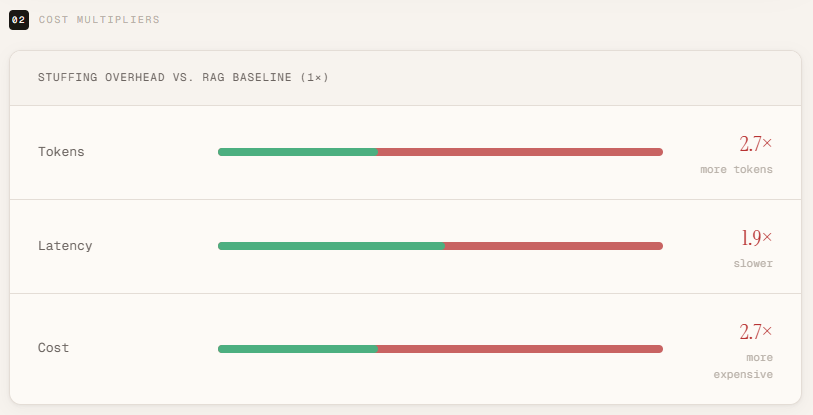

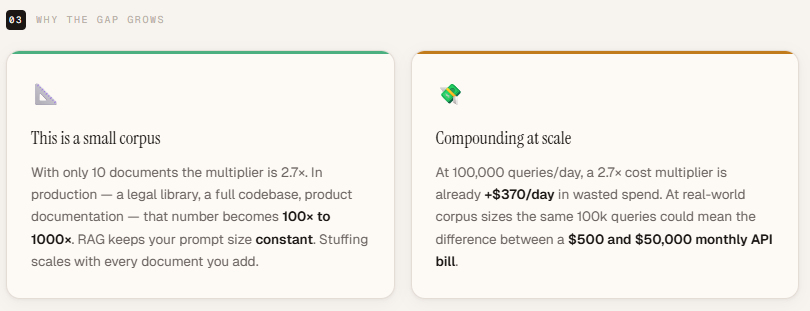

## Lost in the Middle Effect
To demonstrate the “Lost in the Middle” effect, we create a controlled setup where a critical policy update—the needle—states that Enterprise customers with an active HIPAA BAA are entitled to a 90-day refund window instead of the standard 30 days. This clause directly answers the query but is intentionally buried inside roughly 800 tokens of irrelevant filler text designed to simulate a bloated, overstuffed prompt. By asking, “What is the refund window for Enterprise customers with a HIPAA BAA?”, we can test whether the model reliably extracts the buried clause when it is surrounded by noise, illustrating how large context alone does not guarantee accurate attention or retrieval.

In [17]:
NEEDLE = (
    "POLICY UPDATE: Enterprise customers with an active HIPAA BAA "
    "are entitled to a 90-day full refund window, not the standard 30-day window."
)

# ~800 tokens of irrelevant padding to simulate a bloated document
FILLER = (
    "This section covers general platform guidelines and best practices. "
    "Users should ensure they read all documentation before proceeding. "
    "Configuration options may vary depending on the selected plan tier. "
    "Please refer to the onboarding guide for step-by-step instructions. "
    "Support is available 24/7 via chat, email, and phone for Enterprise users. "
) * 30

In [18]:
NEEDLE_QUERY = "What is the refund window for Enterprise customers with a HIPAA BAA?"

In [20]:
def run_lost_in_middle():
    print(f"\n{'='*65}")
    print("  'LOST IN THE MIDDLE' EXPERIMENT")
    print(f"{'='*65}")
    print(f"Query : {NEEDLE_QUERY}")
    print(f"Needle: \"{NEEDLE[:65]}...\"\n")

    # Scenario A: Focused (simulates a good RAG retrieval)
    prompt_a = (
        f"You are a helpful support assistant. "
        f"Answer the question using the context below.\n\n"
        f"CONTEXT:\n{NEEDLE}\n\n"
        f"QUESTION: {NEEDLE_QUERY}"
    )

    # Scenario B: Buried (simulates stuffing — needle is in the middle of noise)
    buried   = f"{FILLER}\n\n{NEEDLE}\n\n{FILLER}"
    prompt_b = (
        f"You are a helpful support assistant. "
        f"Answer the question using the context below.\n\n"
        f"CONTEXT:\n{buried}\n\n"
        f"QUESTION: {NEEDLE_QUERY}"
    )

    print(f"[ A ] Focused context  ({count_tokens(prompt_a):,} input tokens)")
    ans_a, _, _, _ = call_llm(prompt_a)
    print(f"Answer: {ans_a}\n")

    print(f"[ B ] Needle buried in filler  ({count_tokens(prompt_b):,} input tokens)")
    ans_b, _, _, _ = call_llm(prompt_b)
    print(f"Answer: {ans_b}\n")

    print("─" * 65)

In [21]:
run_lost_in_middle()


  'LOST IN THE MIDDLE' EXPERIMENT
Query : What is the refund window for Enterprise customers with a HIPAA BAA?
Needle: "POLICY UPDATE: Enterprise customers with an active HIPAA BAA are ..."

[ A ] Focused context  (67 input tokens)
Answer: The refund window for Enterprise customers with an active HIPAA BAA is 90 days.

[ B ] Needle buried in filler  (3,729 input tokens)
Answer: The refund window for Enterprise customers with an active HIPAA BAA is 90 days.

─────────────────────────────────────────────────────────────────


In this experiment, both setups return the correct answer — 90 days — but the difference in context size is significant. The focused version required only 67 input tokens, delivering the correct response with minimal context. In contrast, the stuffed version required 3,729 input tokens, over 55× more input, to arrive at the same answer.

At this scale, the model was still able to locate the buried clause. However, the result highlights an important principle: correctness alone is not the metric — efficiency and reliability are. As context size increases further, attention diffusion, latency, and cost compound, and retrieval precision becomes increasingly critical. The experiment shows that large context windows can still succeed, but they do so at dramatically higher computational expense and with greater risk as documents grow longer and more complex.

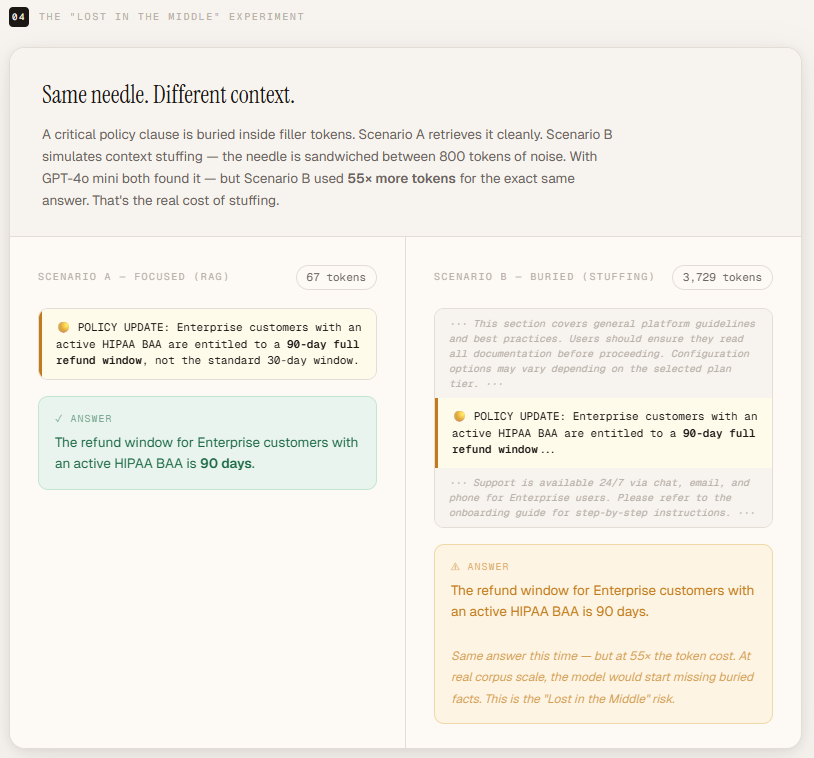